# Monte Carlo Methods
---

Now that we understand some RL basics let's put them into practice.
Please review the following 3 videos briefly before class:

[Incremental Mean](https://www.youtube.com/watch?v=h-8MB7V1LiE)
[Constant Alpha: 1](https://www.youtube.com/watch?v=QFV1nI9Zpoo)
[Constant Alpha: 2](https://www.youtube.com/watch?v=LetHoOtNdJc&t=1s)

## 0.0 Explore the Environment
---
You will need to install a library called gym.
This is maintained by OpenAI and you can find more about it [here](https://gym.openai.com/).
If you enjoy RL, they have a lot of great resources.

In [2]:
# import the stuffs
import sys
import gym
import numpy as np
from collections import defaultdict
from plot_utils import plot_blackjack_values, plot_policy

Next we will "make" the gym environment by creating an instance of the [Blackjack](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py) environment.

In [3]:
env = gym.make('Blackjack-v1')

As mentioned in class, Open AI Gym have a great interface.
We can use this interface to explore some basic characteristics about the environment.
For those new to Python and object-oriented programming, the code is accessing the gym objects instance variables.
Instance variables are variables attached to the object instance and can be accessed with "." notation.
Note that they do not have "()" because they are variables and not object methods aka, functions.

In [4]:
print(f"Observation Space: {env.observation_space}")
print(f"Action Space: {env.action_space}")

Observation Space: Tuple(Discrete(32), Discrete(11), Discrete(2))
Action Space: Discrete(2)


Both the state space and the action space are discrete.

### 0.1 State Space
Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether the player has a usable ace (`no` $=0$, `yes` $=1$).

### 0.2 Action Space
The agent has two potential actions:

```
    STICK = 0
    HIT = 1
```

### 0.3 Reward Function
The reward function for blackjack is simple:
```
    Win = 1
    Loss = 0
```

First lets get some basic intuition for how the code is working by playing a few games with a random policy $\pi_{random}$.

In [5]:
for i_episode in range(3):
    # the .reset() is an object method that resets the environment state and returns the initial state
    state = env.reset()
    done = False
    while not done:
        print(f"State: {state}")
        # we can get a random action with the .action_space.sample() method
        action = env.action_space.sample()
        # the .step() method that takes as input the chosen action and moves the environment through one iteration
        state, reward, done, info = env.step(action)
        if done:
            print('End game! Reward: ', reward)
            print('You won! \n') if reward > 0 else print('You lost! \n')
            break

State: (12, 10, False)
State: (21, 10, False)
End game! Reward:  -1.0
You lost! 

State: (17, 4, False)
State: (18, 4, False)
End game! Reward:  -1.0
You lost! 

State: (18, 2, False)
End game! Reward:  -1.0
You lost! 



## 1.0 MC Prediction, First Visit Incremental Mean
---

Now lets move on to some more interesting stuff and estimate the action value function $q(s,a)$.

### 1.1 Stochastic Policy
We will begin by investigating a policy where the player _almost_ always sticks if the sum of her cards exceeds 18.
We will do this with some probability that we will feed into the function.

The function accepts as **input**:
- `bj_env`: This is an instance of Blackjack environment.
- `prob`: This is the probability that the agent sticks if sum > 18

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.


In [6]:
def stochastic_episode(bj_env, probability):
    """
    Conducts an episode with a stochastic policy.
    :param bj_env: instance Blackjack environment
    :param probability: probability that agent sticks if hand > 18
    :return: list of (state, action, reward) tuples
    """
    episode = []
    state = bj_env.reset()
    done = False
    while not done:
        probs = [probability, 1 - probability] if state[0] > 18 else [1 - probability, probability]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

Now that we have all that logic wrapped up in a function, we can easily use it to generate episode data.

In [7]:
probability = 0.8
for i in range(3):
    episode = stochastic_episode(env, probability)
    print(f"Episode {i+1}: {episode}")

Episode 1: [((20, 7, False), 1, -1.0)]
Episode 2: [((12, 7, False), 1, -1.0)]
Episode 3: [((14, 5, False), 0, 1.0)]


## 1.2 Discounted Reward
Next we want to make a function that takes in some rewards and returns the discounted rewards according to some discount factor gamma $\gamma$.

Recall that the discounted return is related to gamma as follows:

$$ \gamma^0R_{t+1} , \gamma^1R_{t+2},\ldots \gamma^nR_{t+n-1}$$


In [47]:
def get_discounted_rewards(rewards, gamma):
    """
    Calculates discounted rewards.
    :param rewards: list of rewards for episode
    :param gamma: discount rate
    :return: list of discounted rewards
    """
    # TODO: calculate discounted returns
    discounted_rewards = rewards@gamma
    return discounted_rewards

### 1.3 Populating the Q-table
With these tools we can do some MC prediction.
Recall that with MC prediction, we are just using a stochastic policy to estimate the action value function.

Your algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: Number of time we play the game.
- `generate_episode`: This is a function handle that generates an episode.
- `gamma`: This is the discount rate. $\gamma \in [0,1]$ set close to 1.

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Remember that when you calculate the value of state action pair you are using the **Return** rather than the **Reward**.

Recall the **Return** $G_t$ is the total discounted reward from time-step $t$.
$$ G_t = \gamma^0R_{t+1} + \gamma^1R_{t+2}+\ldots = \sum_{k=0}^{\infty} \gamma^k R_{t+k+1}$$

To populate the Q table recall that we are using an incremental average such that:

- `Q`: action value for given state and action pair
- `N`: number of times that action value par has been visited
- `G`: discounted **Return**

$$ Q \leftarrow Q + \frac{1}{N}(G - Q)$$

In [82]:
def generate_q_table(env, num_episodes, generate_episode, gamma=1.0, probability=0.8):
    """
    Generates an action value table
    :param env: Open AI Gym
    :param num_episodes: number of episodes
    :param generate_episode: function handle for generating episodes, PASS IN FUNCTION WITHOUT ()
    :param gamma: discount rate
    :param probability: probability that agent hits if sum > 18
    :return: Q table
    """

    # we are using defaultdict objects so that we can have standard values for all key's without raising a key error
    # we access these dicts using [state][action[i]] as the key and the value corresponds to the dictionaries name
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # TODO: generate an episode
        episode = generate_episode(env, probability)
        # TODO: unpack the episode into its components
        states, actions, rewards = zip(*episode)
        # TODO: calculate the discounted reward
        discounts = get_discounted_rewards(rewards, np.array([gamma**i for i in range(len(rewards))]))
        # TODO: Iterate through the episode components and populate the Q-Table
        for i, state in enumerate(states):
            N[state][actions[i]] += 1.0
            Q[state][actions[i]] += 1.0/N[state][actions[i]]*(discounts-Q[state][actions[i]])
    return Q


Now let's visualize the state-value function.

Play with the number of episodes and observe how that alters the Q-table estimation.

It should look like shit with the current episode numbers.

0.0
0.0
-1.0
1.0
1.0
1.0
1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
0.0
0.0
-1.0
1.0
-1.0
-1.0
0.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
0.0
-1.0
0.0
-1.0
-1.0
1.0
1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
0.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
0.0
1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
0.0
-1.0
1.0
-1.0
-1.0
0.0
1.0
0.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
0.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
1.0
0.0
-1.0
-1.0
-1.0
0.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
0.0
1.0
-1.0


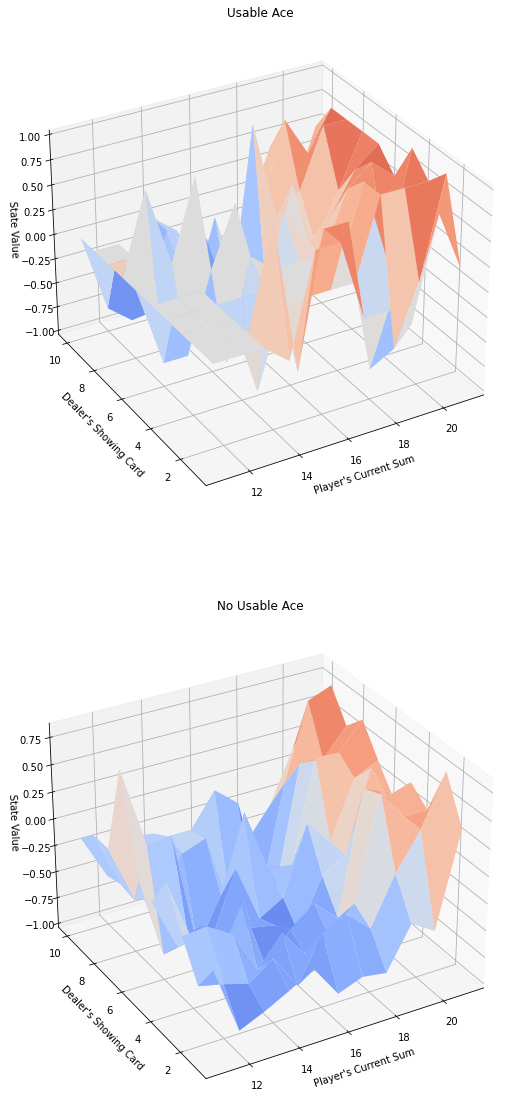

In [83]:
# obtain the action-value function
probability = 0.8
gamma = 1.0
episodes = int(1e3)
Q = generate_q_table(env, episodes, stochastic_episode, gamma, probability)

# obtain the corresponding state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([probability, 1 - probability],v)) + (k[0]<=18)*(np.dot([1 - probability, probability],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)

### Optional Programming Challenge
Because we are programmers and not mathematicians, we can do things a little differently.

With one additional default dict we can calculate the running average in a way that does not require the incremental mean formula.

-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
0.0
1.0
1.0
1.0
0.0
1.0
1.0
1.0
-1.0
0.0
1.0
1.0
1.0
-1.0
0.0
1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
0.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
0.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
0.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
0.0
-1.0
0.0
1.0
1.0
1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
0.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
0.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
0.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
0.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-

Episode 2000/100000.-1.0
0.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
0.0
1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
-1.0
1.0
0.0
-1.0
1.0
-1.0
-1.0
-1.0
0.0
-1.0
1.0
-1.0
-1.0
1.0
0.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
1.0
1.0
1.0
0.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
0.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-

-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
1.0
0.0
1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
1.0
1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
1.0
1.0
1.0
1.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
Episode 4000/100000.1.0
-1.0
0.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0

-1.0
1.0
0.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
0.0
0.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
1.0
0.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
0.0
0.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
0.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
0.0
-1.0
-1.0
-1.0
1.0
-1.0
0.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
0.0
0.0
-1.0
-1.0
-1.0
1.0
-1.

-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
0.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
0.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
0.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
1.0
0.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
1.0
-1.0
0.0
1.0
-1.0
1.0
1.0
0.0
1.0
1.0
-1.0
0.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
-1.0
1.0
-1.0
0.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
0.0
1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
0.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
0.0
-1.0

Episode 11000/100000.-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
0.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
0.0
-1.0
-1.0
-1.0
-1.0
1.0
0.0
-1.0
0.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
0.0
-1.0
1.0
1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
0.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
0.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
0.0
1.0
0.0
-1.0
-1.0
0.0
1.0
0.0
-1.0
-1.0
1.0
-1.0
1.0
0.0
-1.0
-1.0
-1.0
-1.0
1.0
0.0
-1.0
0.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
0.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0

1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
0.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
0.0
1.0
1.0
0.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
0.0
-1.0
-1.0
-1.0
-1.0
0.0
0.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
0.0
0.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
0.0
-1.0
-1.0
1.0
-1.0
0.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
0.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
Episode 13000/100

1.0
-1.0
1.0
0.0
0.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
0.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
0.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
0.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
1.0
-1.0
0.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
0.0
-1.0
-1.0
0.0
1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
0.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
0.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
1

-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
0.0
1.0
1.0
-1.0
0.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
0.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
0.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
0.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
1.0
1.0
1.0
-1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
0.0
0.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
1.0
0.0
-1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.

1.0
-1.0
0.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
0.0
1.0
-1.0
-1.0
1.0
-1.0
0.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
0.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
0.0
1.0
-1.0
0.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
1.0
0.0
-1.0
-1.0
1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
0.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
0.0
1.0
-1.0
0.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
1.0
-1.0
0.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.

-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
0.0
-1.0
-1.0
-1.0
1.0
1.0
0.0
0.0
1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
0.0
1.0
-1.0
0.0
1.0
1.0
0.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
0.0
0.0
1.0
1.0
1.0
-1.0
1.0
-1.0
0.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
0.0
1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
0.0
1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
0.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
0.0
0.0
1.0
1.0
1.0
-1.0
1

-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
Episode 22000/100000.1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
0.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
0.0
1.0
1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
0.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
0.0
0.0
1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
0.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
1.0
0.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0

-1.0
-1.0
-1.0
-1.0
1.0
0.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
1.0
1.0
0.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
0.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
0.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
0.0
1.0
1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
0.0
-1.0
0.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
0.0
1.0
-1.0
-1.0
0.0
0.0
1.0
1.0
-1.0
0.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
0.0
-1.0
-1.0
0.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0


-1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
0.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
0.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
1.0
0.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
0.0
-1.0
0.0
-1.0
0.0
1.0
-1.0
-1.0
0.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
0.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
0.0
1.0
1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0


1.0
-1.0
0.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
0.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
0.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
0.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
0.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
0.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
1.0
-1.0
0.0
0.0
1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
0.0
-1.0
-1.0
1.0
-1.0


-1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
1.0
0.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
0.0
-1.0
0.0
0.0
1.0
0.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
-1.0
1.0
0.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
0.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
0.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
0.0
-1.0
-1.0
-1.0
-1.0
0.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
0.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
0.0
0.0
1.0
-1.0
-1.0
-1.0
1.0
0

-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
0.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
1.0
1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
0.0
-1.0
1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
0.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
0.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
0.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
0.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
1.0
0.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
0.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
0.0
-1.

Episode 33000/100000.1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
0.0
0.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
0.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
0.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
0.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
0.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
0.0
-1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
0.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
0.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0


-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
0.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
0.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
0.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
0.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
0.0
-1.0
0.0
1.0
1.0
-1.0
1.0
0.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
0.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
0.0
-1.0
-1.0
-1.0
1.0
0.0
Episod

-1.0
-1.0
-1.0
1.0
-1.0
0.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
0.0
1.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
0.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
0.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
0.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1

-1.0
0.0
1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
0.0
-1.0
-1.0
1.0
1.0
1.0
1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
1.0
0.0
1.0
1.0
0.0
-1.0
-1.0
1.0
-1.0
1.0
0.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
0.0
-1.0
-1.0
0.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
0.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
0.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
0.0
1.0
1.0
0.0
-1.0
-1.0
-1.0
1.0
-1.0
-1

-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
0.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
0.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
0.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
0.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
0.0
-1.0
1.0
-1.0
1.0
0.0
1.0
-1.0
0.0
-1.0
-1.0
1.0
-1.0
0.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
0.0
1.0
-1.0
1.0
-1.0
0.0
-1.0
-1.0
0.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
0.0
1.0
1.0
-1.0
0.0
1.0
-1.0
-1.0
-1.0


-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
1.0
0.0
0.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
0.0
1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
1.0
1.0
1.0
0.0
-1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
1.0
0.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
0.0
1.0
-1.0
1.0
1.0
-1.0
0.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.

-1.0
1.0
-1.0
1.0
1.0
0.0
-1.0
-1.0
-1.0
0.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
1.0
1.0
-1.0
Episode 44000/100000.1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
0.0
1.0
0.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
0.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
0.0
1.0
1.0
-1.0
0.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
1.0
0.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
0.0
1.0
-1.0
-1.0
1.0
0.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
0.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
0.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
0.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
1

-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
0.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
0.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
0.0
-1.0
0.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
0.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
0.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
0.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
0.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
0.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
Episode 46000/100000.-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0

-1.0
1.0
1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
0.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
0.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
0.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
0.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
0.0
1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
1.0
1.0
-1.0
0.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
0.0
-1.0
-1.0
1.0
0.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
0.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
-1.0
-

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
0.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
0.0
1.0
1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
0.0
1.0
0.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
0.0
-1.0
1.0
1.0
1.0
-1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
0.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
0.0
-1.0
0.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0


-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
1.0
0.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
0.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
0.0
1.0
-1.0
0.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
0.0
1.0
1.0
0.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
0.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
0.0
1.0
1.0
-1.0
0.0
-1.0
0.0
-1.0
1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
0.0
1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
0.0
-1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
0.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
1.0
1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
0.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
0.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
0.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
0.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
0.0
1.0
1.0
1.0
1.0
-1.0
0.0
-1.0
0.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
1.0

-1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
0.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
0.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
1.0
-1.0
1.0
1.0
0.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
0.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
0.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
0.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
0.0
0.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
0.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
0.0
0.0
1.0
-1.0
0.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0

Episode 59000/100000.0.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
0.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
0.0
1.0
-1.0
1.0
0.0
-1.0
0.0
0.0
-1.0
1.0
1.0
0.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
0.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
0.0
0.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
0.0
1.0
1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
0.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0


-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
0.0
-1.0
1.0
1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
0.0
1.0
-1.0
0.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
0.0
1.0
1.0
-1.0
0.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
0.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
0.0
1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
0.0
1.0
0.0
1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
0.0
-1.0
-1.0
1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
Episode 61000/100000.1.0
1.0
-1.0
1.0
0.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
0.0
-1.0
1.0
1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1

1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
1.0
0.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
0.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
0.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
0.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
0.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
0.0
-1.0
1.0
1.0
0.0
-1.0
0.0
-1.0
1.0
0.0
-1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
0.0
1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
0.0
-1.0
1.0
-1.0
1.0

-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
0.0
-1.0
1.0
0.0
1.0
-1.0
-1.0
1.0
0.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
1.0
0.0
-1.0
1.0
1.0
-1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
0.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
0.0
0.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
1.0
-1.0
1.0
0.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
1.0
0.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
0.0
-1.0
1.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1

-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
0.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
0.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
0.0
1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.

1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
0.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
0.0
1.0
-1.0
1.0
1.0
1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
0.0
-1.0
-1.0
0.0
1.0
-1.0
-1.0
1.0
0.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
0.0
-1.0
1.0
-1.0
-1.0
0.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
0.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
-1.0
-1.

-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
Episode 70000/100000.-1.0
1.0
-1.0
0.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
0.0
1.0
1.0
-1.0
1.0
0.0
0.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
0.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
0.0
0.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
0.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
0.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
0.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
0.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
0.0
-1.0
0.0
1.0
-1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
-1.0


0.0
-1.0
1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
0.0
0.0
-1.0
1.0
-1.0
0.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
0.0
1.0
-1.0
1.0
1.0
-1.0
0.0
-1.0
1.0
-1.0
0.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
0.0
-1.0
1.0
1.0
-1.0
0.0
1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
0.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
Episode 72000/100000.1.0
0.0
1.0
-1.0
0.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
0.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
0.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
0.0
1.0
-1.0
-1.0
-1.0
0.0
1.0
1.0
-1.0
0.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
1

-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
-1.0
1.0
0.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
0.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
0.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
0.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
0.0
0.0
-1.0
-1.0
0.0
1.0
1.0
1.0
-1.0
1.0
1.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
Episode 74000/100000.-1.0
-1.0
1.0
0.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.

1.0
1.0
1.0
0.0
0.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
0.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
0.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
-1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
0.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
0.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
1.0
-1.0
1.0
1.0
1.

-1.0
1.0
0.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
0.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
1.0
0.0
-1.0
1.0
1.0
1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
0.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
0.0
-1.0
1.0
0.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
0.0
-1.0
-1.0
1.0
1.0
0.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
0.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
0.0
-1.0
-1.0
1.0
1

1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
0.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
0.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
0.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
1.0
-1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
0.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
0.0
1.0
-1.0
-1.0


-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
0.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
0.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
0.0
0.0
-1.0
1.0
1.0
1.0
-1.0
0.0
1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
0.0
1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
0.0
-1.0
-1.0
0.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
0.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-

Episode 83000/100000.-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
0.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
1.0
1.0
-1.0
1.0
0.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
0.0
-1.0
1.0
-1.0
1.0
-1.0
0.0
1.0
1.0
-1.0
-1.0
0.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
0.0
0.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
0.0
1.0
-1.0
-1.0
0.0
1.0
-1.0
1.0
-1.0
0.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
1.0
-1.0
-1.0
0.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
0.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.

-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
0.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
0.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
0.0
-1.0
1.0
1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
0.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
Episode 85000/100000.-1.0
1.0
-1.0
1.0

1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
0.0
-1.0
1.0
0.0
1.0
0.0
-1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
0.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
0.0
1.0
-1.0
1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
0.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
1.0
1.0
1.0
1.0
1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
0.0
1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
1.0
-1.0
1.0
-1.0
1.0
1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
1.0
-1.0
1.0
1.0


-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
0.0
1.0
1.0
-1.0
0.0
-1.0
0.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
0.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
0.0
1.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
0.0
-1.0
0.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
0.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
0.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
1.0
1.0
1.0
1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
0.0
-1.0
1.0
-1.0
1.0
0.0
0.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
0.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
0.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
0.0
-1.0
0.0
-1.0
-1.0
0.0
1.0
-1.0
0.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
1

-1.0
0.0
1.0
-1.0
-1.0
1.0
1.0
1.0
0.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
0.0
-1.0
1.0
0.0
1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
0.0
1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
0.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
0.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1

-1.0
-1.0
1.0
-1.0
0.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
0.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
0.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
0.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
0.0
-1.0
1.0
1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
1

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
0.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
0.0
1.0
-1.0
-1.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
1.0
-1.0
Episode 94000/100000.-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
0.0
-1.0
1.0
1.0
1.0
-1.0
1.0
0.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
0.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
0.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
0.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
0.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0


1.0
0.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
0.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
0.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
0.0
1.0
-1.0
-1.0
0.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
0.0
1.0
1.0
-1.0
0.0
-1.0
-1.0
0.0
1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
1.0
1.0
0.0
1.0
0.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
0.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
1.0
-1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
0.0
-1.0
1.0
0.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.

-1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
0.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
0.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
0.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
1.0
1.0
-1.0
0.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
0.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
1.0
0.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
0.0
-1.0
0.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
0.0
1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
1.

-1.0
-1.0
0.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
0.0
0.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
0.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
0.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
0.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
0.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0

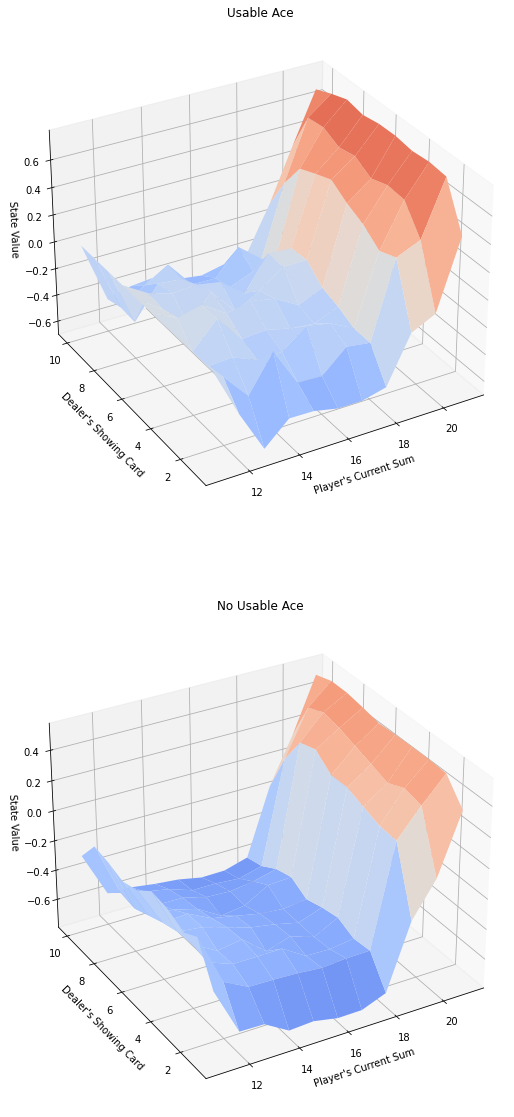

In [84]:
def programers_q_table(env, num_episodes, generate_episode, gamma=1.0, probability=0.8):
    """
    Generates an action value table
    :param env: Open AI Gym
    :param num_episodes: number of episodes
    :param generate_episode: function handle for generating episodes, PASS IN FUNCTION WITHOUT ()
    :param gamma: discount rate
    :return: Q table
    """

    # we are using defaultdict objects so that we can have standard values for all key's without raising a key error
    # we access these dicts using [state][action[i]] as the key and the value corresponds to the dictionaries name
    total_returns = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # TODO: generate an episode
        episode = generate_episode(env, probability)
        # TODO: unpack the episode into its components
        states, actions, rewards = zip(*episode)
        # TODO: calculate the discounted reward
        discounts = get_discounted_rewards(rewards, np.array([gamma**i for i in range(len(rewards))]))
        # TODO: Iterate through the episode components and populate the Q-Table
        for i, state in enumerate(states):
            N[state][actions[i]] += 1.0
            Q[state][actions[i]] += 1.0/N[state][actions[i]]*(discounts-Q[state][actions[i]])

    return Q

# obtain the action-value function
probability = 0.8
gamma = 1.0
episodes = int(1e5)
Q = generate_q_table(env, episodes, stochastic_episode, gamma, probability)

# obtain the corresponding state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([probability, 1 - probability],v)) + (k[0]<=18)*(np.dot([1 - probability, probability],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)

### 2.0 MC Control, Constant Alpha

But what if we want the most recent experiences to have more weight compared to the collection of experience we already have?
For that we will have to weight the running average.

This is called constant-$\alpha$ MC control.

We will also be using an $\epsilon$ greedy policy which says we chose a random action with probability $\epsilon)$.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: Number of games we play.
- `alpha`: Moving average weight. $\alpha \in [0,1]$ set close to 0.
- `gamma`: This is the discount rate. $\gamma \in [0,1]$ set close to 1.

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.

Recall that with constant alpha our update to the action value function is as follows:

$$Q(s,a) \leftarrow (1 - \alpha) * Q(s,a) + \alpha * G(s,a)$$

These are the functions I used to make my code nice and clean.
Feel free to use them or make your own.


In [ ]:
def generate_episode(env, Q, epsilon):
    """
    Generate Episode with epsilon greedy policy.
    :param env: Open AI Blackjack environment
    :param Q: Action-value table
    :param epsilon: probability that we chose a random action
    :return: list of tupes(state, action, reward) for episode
    """
    # TODO: run an episode, similar to first part but with epsilon greedy policy for choosing action
    episode = []
    state = env.reset()
    done = False
    while not done:
        probs = [epsilon, 1 -epsilon] if state[0] > 18 else [1 - epsilon, epsilon]
        action = np.random.choice(np.arange(2), p=epsilon)
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break

    return episode

def update_Q(episode, Q, alpha, gamma):
    """
    Update the Q-table
    :param episode: list of tuples(state, action, reward)
    :param Q: action-value table
    :param alpha: running average weighting
    :param gamma: reward discount
    :return: new action-value table
    """
    # TODO: similar to first part but with new update rule

    return None


def mc_control(env, num_episodes, alpha, gamma=1.0):

    # initialize Q-table
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    for i_episode in range(1, num_episodes+1):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # TODO: decay epsilon

        # TODO: complete generate_episode()

        # TODO: complete update_Q()

    return policy, Q

Now run some MC control!

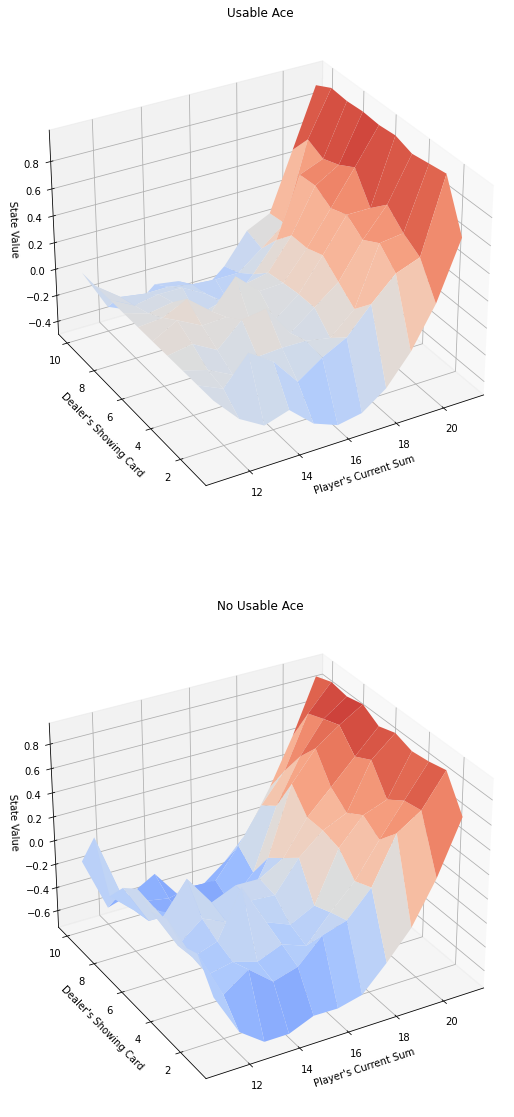

In [54]:
num_episodes = int(1e5)
alpha = None
policy, Q = mc_control(env, num_episodes, alpha)


In [ ]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

Finally, we visualize the policy that is estimated to be optimal.

In [ ]:
plot_policy(policy)